In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
import random
from scipy import optimize
from sklearn.cluster import KMeans


In [187]:
# Download the data
ticker = 'SPY'
start_date = '2022-12-01'
end_date = '2023-12-31'

data = yf.download(ticker, start=start_date, end=end_date)
data.columns = data.columns.droplevel(['Ticker'])
data = data[['Close']]

data['r'] = np.log(data['Close'] / data['Close'].shift(1)) * 100
data = data[['r', 'Close']]
data.dropna(axis=0, inplace=True)

# Date indicates the beginning of the day, data indicates
data['r_yesterday'] = data['r'].shift(1)
data['r_diff_1'] = abs(data['r'].shift(1) - data['r'].shift(2))
data['r_diff_2'] = abs(data['r'].shift(2) - data['r'].shift(3))

windows = [6, 14]
for w in windows:
    data[f'r_mean_{w}'] = data['r'].rolling(w).mean()
    data[f'r_std_{w}'] = data['r'].rolling(w).std()
    data[f'r_left_mean_{w}'] = data['r'].shift(int(w/2)).rolling(int(w/2)).mean()
    data[f'r_left_std_{w}'] = data['r'].shift(int(w/2)).rolling(int(w/2)).std()
    data[f'r_right_mean_{w}'] = data['r'].rolling(int(w/2)).mean()
    data[f'r_right_std_{w}'] = data['r'].rolling(int(w/2)).std()

data = data.dropna(axis=0)
data = data[data.index >= '2023-01-01']
data

[*********************100%***********************]  1 of 1 completed


Price,r,Close,r_yesterday,r_diff_1,r_diff_2,r_mean_6,r_std_6,r_left_mean_6,r_left_std_6,r_right_mean_6,r_right_std_6,r_mean_14,r_std_14,r_left_mean_14,r_left_std_14,r_right_mean_14,r_right_std_14
Date,,,,,,,,,,,,,,,,,
2023-01-03,-0.421877,370.367889,-0.263750,2.047778,3.034611,0.004377,1.046831,-0.357379,0.912669,0.366134,1.230475,-0.299484,1.168799,-0.397448,1.314346,-0.201519,1.099985
2023-01-04,0.769055,373.227203,-0.421877,0.158127,2.047778,0.036956,1.070854,0.046102,1.564684,0.027810,0.646788,-0.298419,1.169840,-0.710454,1.253896,0.113617,0.998372
2023-01-05,-1.147905,368.967407,0.769055,1.190932,0.158127,-0.088505,1.171016,0.089899,1.547907,-0.266909,0.967830,-0.334597,1.188939,-0.536883,1.345773,-0.132310,1.075251
2023-01-06,2.267307,377.428589,-1.147905,1.916960,1.190932,0.497810,1.341136,0.366134,1.230475,0.629486,1.711878,0.004253,1.207376,-0.239534,1.041263,0.248040,1.391247
2023-01-09,-0.056705,377.214630,2.267307,3.415212,1.916960,0.191021,1.190095,0.027810,0.646788,0.354233,1.744296,0.085033,1.158334,-0.248527,1.051042,0.418594,1.242094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.200763,467.651276,0.943722,2.339131,2.001644,0.125243,0.835858,0.334128,0.432665,-0.083642,1.195219,0.289357,0.660845,0.425589,0.561477,0.153126,0.766588
2023-12-26,0.421357,469.625916,0.200763,0.742959,2.339131,0.222934,0.829409,-0.076080,1.142797,0.521947,0.381557,0.320862,0.655469,0.474178,0.530376,0.167545,0.771195
2023-12-27,0.180658,470.475098,0.421357,0.220595,0.742959,0.159554,0.812778,0.051516,1.264385,0.267593,0.133543,0.362608,0.623604,0.508322,0.468521,0.216894,0.757312


# Statistical Jump Model

In [188]:
# Parameter settings

df = data.drop(columns=['r', 'Close'])
jump_penalty = 0.0005
n_features = 15
n_data = len(df)

n_states = 2
possible_states = [i for i in range(n_states)]

loss_tolerance = 0.0000001

df

Price,r_yesterday,r_diff_1,r_diff_2,r_mean_6,r_std_6,r_left_mean_6,r_left_std_6,r_right_mean_6,r_right_std_6,r_mean_14,r_std_14,r_left_mean_14,r_left_std_14,r_right_mean_14,r_right_std_14
Date,,,,,,,,,,,,,,,
2023-01-03,-0.263750,2.047778,3.034611,0.004377,1.046831,-0.357379,0.912669,0.366134,1.230475,-0.299484,1.168799,-0.397448,1.314346,-0.201519,1.099985
2023-01-04,-0.421877,0.158127,2.047778,0.036956,1.070854,0.046102,1.564684,0.027810,0.646788,-0.298419,1.169840,-0.710454,1.253896,0.113617,0.998372
2023-01-05,0.769055,1.190932,0.158127,-0.088505,1.171016,0.089899,1.547907,-0.266909,0.967830,-0.334597,1.188939,-0.536883,1.345773,-0.132310,1.075251
2023-01-06,-1.147905,1.916960,1.190932,0.497810,1.341136,0.366134,1.230475,0.629486,1.711878,0.004253,1.207376,-0.239534,1.041263,0.248040,1.391247
2023-01-09,2.267307,3.415212,1.916960,0.191021,1.190095,0.027810,0.646788,0.354233,1.744296,0.085033,1.158334,-0.248527,1.051042,0.418594,1.242094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.943722,2.339131,2.001644,0.125243,0.835858,0.334128,0.432665,-0.083642,1.195219,0.289357,0.660845,0.425589,0.561477,0.153126,0.766588
2023-12-26,0.200763,0.742959,2.339131,0.222934,0.829409,-0.076080,1.142797,0.521947,0.381557,0.320862,0.655469,0.474178,0.530376,0.167545,0.771195
2023-12-27,0.421357,0.220595,0.742959,0.159554,0.812778,0.051516,1.264385,0.267593,0.133543,0.362608,0.623604,0.508322,0.468521,0.216894,0.757312


In [159]:
# Get the total distance from the centered states

def objective_func(arr):
    state_features_f = []
    for i in range(n_states):
        state_features_f.append(arr[i*n_features: (i+1)*n_features])

    dist_ls = []

    for i in range(len(df)):
        features = np.array(df.iloc[i, :])
        state = state_seq[i]

        diff = np.abs(features - state_features_f[state])
        dist = np.sum(diff**2)
        dist_ls.append(dist)

    dist_total = np.sum(dist_ls)

    return dist_total

In [166]:
# 1. Better initialization
def initialize_states(df, n_states, random_seed):
    # Use k-means for better initialization
    kmeans = KMeans(n_clusters=n_states, random_state=random_seed)
    clusters = kmeans.fit_predict(df)
    
    # Initialize state sequence based on kmeans
    state_seq = clusters
    
    # Initialize state features as cluster centers
    state_features_ls = kmeans.cluster_centers_
    
    return state_seq, state_features_ls

Seed 715: Iteration 0, loss 618.1854747705878
Seed 715: Iteration 1, loss 618.1854747705884
Seed 715: Iteration 2, loss 618.1854747705884
Seed 715: Iteration 3, loss 618.185474770588
Seed 715: Iteration 4, loss 618.1854747705883
Seed 631: Iteration 0, loss 610.8343930618771
Seed 631: Iteration 1, loss 610.8343930618773
Seed 631: Iteration 2, loss 610.8343930618778
Seed 631: Iteration 3, loss 610.8343930618777
Seed 631: Iteration 4, loss 610.8343930618772
Seed 651: Iteration 0, loss 611.9353705846147
Seed 651: Iteration 1, loss 611.9353705846149
Seed 651: Iteration 2, loss 611.9353705846148
Seed 651: Iteration 3, loss 611.9353705846146
Seed 651: Iteration 4, loss 611.9353705846144
Seed 568: Iteration 0, loss 616.4517666531474
Seed 568: Iteration 1, loss 616.4517666531474
Seed 568: Iteration 2, loss 616.4517666531475
Seed 568: Iteration 3, loss 616.4517666531474
Seed 568: Iteration 4, loss 616.4517666531469
Seed 844: Iteration 0, loss 611.6958514819052
Seed 844: Iteration 1, loss 611.695

/var/folders/4f/6jz6fz0s5qzb8bn1kt7qww900000gn/T/ipykernel_3805/3469668458.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['state'] = state_seq
/var/folders/4f/6jz6fz0s5qzb8bn1kt7qww900000gn/T/ipykernel_3805/3469668458.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df_plot['state'][i] == 0:


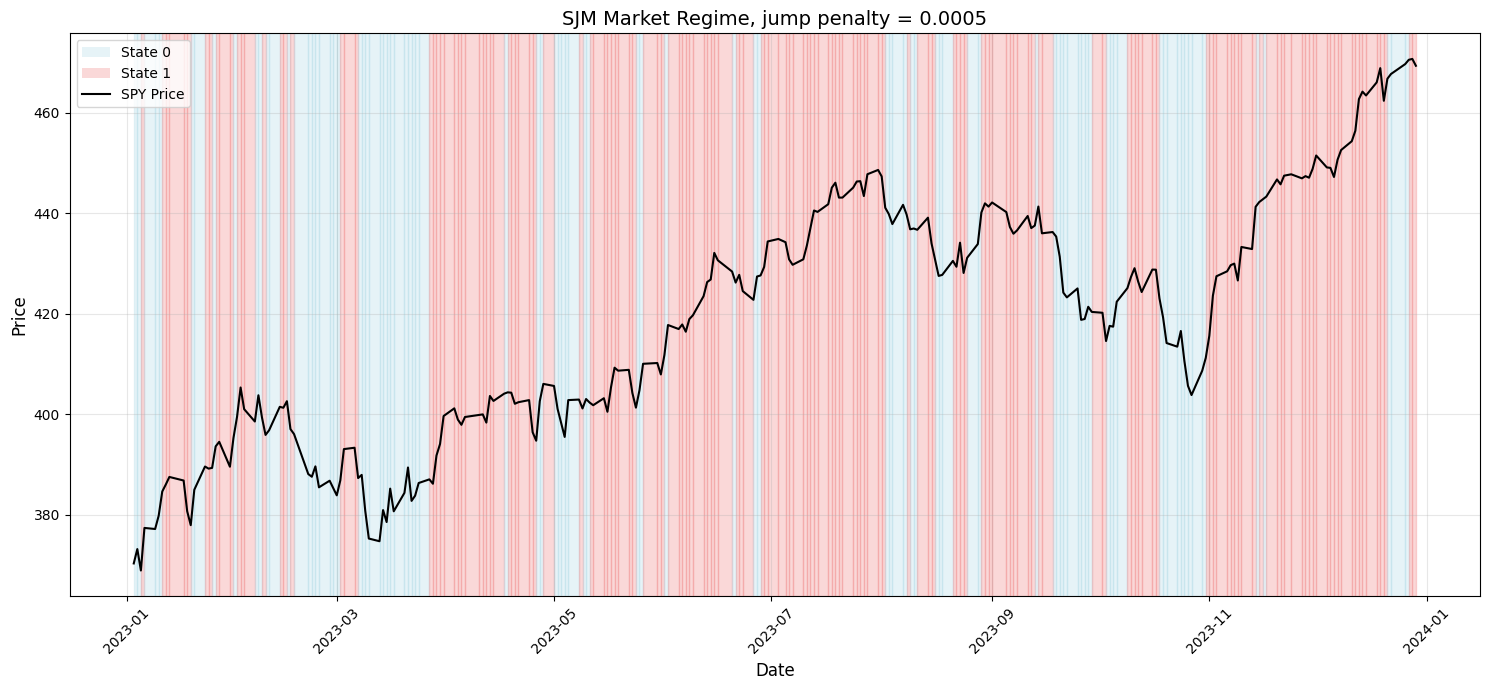

In [195]:
######## Coordinate Descent Algoirthm

jump_penalty = 0.0005

# key is the random seed, value is dict of state sequence and centered state features
result_dict = {}

for trial in range(10):
    random_seed = random.randint(0, 1000)
    loss_ls = []
    ii = 0
    # Initialize the fixed state sequence
    state_seq, state_features_ls = initialize_states(df, n_states, random_seed)

    tol = 100000

    while tol > loss_tolerance or ii < 5:
        # 1. Optimize the centered state features, fixing the state sequence
        n_variables = n_states * n_features
        # Initialize the centered state features, which is to be optimized
        state_features = np.concatenate((state_features_ls[0],state_features_ls[1]))

        result = optimize.minimize(
            objective_func,
            state_features,
            method='L-BFGS-B',
            bounds=[(-100, 100) for _ in range(n_variables)],
            options={'maxiter': 1000}
        )

        # Updated centered state features
        state_features_ls = [result.x[i*n_features: (i+1)*n_features] for i in range(n_states)]

        # 2. Optimize the state sequence, fixiing the centered state features.
        dist_matrix = np.zeros((len(df), n_states))
        arr_df = np.array(df)

        for i in range(len(dist_matrix)):
            for j in range(n_states):
                dist_matrix[i,j] = np.sum((np.array(arr_df[i, :]) - state_features_ls[j])**2)

        optimal_states = [0 for _ in range(len(df))]
        loss_matrix = np.zeros((len(df), n_states))

        # Initialized the first row of the loss matrix
        for k in range(n_states):
            loss_matrix[0, k] = dist_matrix[0, k]

        # Loop forward to fill the loss matrix
        for t in range(1, len(df)):
            for k in range(n_states):
                loss_inc = min([loss_matrix[t-1, j] + jump_penalty * int(j!=k) for j in range(n_states)])
                loss_matrix[t, k] = dist_matrix[t, k] + loss_inc

        loss_total = min(loss_matrix[-1, :])

        # Loop backward to find the optimal state sequence
        optimal_states[-1] = int(np.argmin(loss_matrix[-1, :]))

        for t in range(len(df)-2, -1, -1):
            loss_inc_back = [loss_matrix[t,j] + jump_penalty*int(j!=optimal_states[t+1]) for j in range(n_states)]
            optimal_states[t] = int(np.argmin(loss_inc_back))

        # The newly updated state sequence
        state_seq = optimal_states
            
        if ii == 0:
            loss_ls.append(loss_total)
            print(f'Seed {random_seed}: Iteration {ii}, loss {loss_total}')
            ii += 1
            continue
        else:
            tol = np.abs(loss_total - loss_ls[-1])

        loss_ls.append(loss_total)
        print(f'Seed {random_seed}: Iteration {ii}, loss {loss_total}')
        ii += 1

    result_dict[random_seed] = {'state_seq': state_seq, 'state_features_ls': state_features_ls, 'loss_total': loss_total}


results = list(result_dict.values())
results = sorted(results, key=lambda x: x['loss_total'], reverse=True)
state_seq = results[-1]['state_seq']
state_features_ls = results[-1]['state_features_ls']


df_plot = data[['Close', 'r']]
df_plot['state'] = state_seq


plt.figure(figsize=(15, 7))

plt.plot(df_plot.index, df_plot['Close'], 'k-', linewidth=1.5, zorder=2)

# Add shading for different states
for i in range(len(df_plot)-1):
    if df_plot['state'][i] == 0:
        plt.axvspan(df_plot.index[i], df_plot.index[i+1], color='lightblue', alpha=0.3, zorder=1)
    else:
        plt.axvspan(df_plot.index[i], df_plot.index[i+1], color='lightcoral', alpha=0.3, zorder=1)

# Formatting
 # Formatting
plt.title(f'SJM Market Regime, jump penalty = {jump_penalty}', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightblue', alpha=0.3, label='State 0'),
    Patch(facecolor='lightcoral', alpha=0.3, label='State 1'),
    plt.Line2D([0], [0], color='k', label='SPY Price')
]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()


Seed 925: Iteration 0, loss 611.4195620082136
Seed 925: Iteration 1, loss 611.4195620082138
Seed 925: Iteration 2, loss 611.4195620082138
Seed 925: Iteration 3, loss 611.4195620082138
Seed 925: Iteration 4, loss 611.4195620082138
Seed 33: Iteration 0, loss 618.2182091988017
Seed 33: Iteration 1, loss 618.2182091988014
Seed 33: Iteration 2, loss 618.2182091988013
Seed 33: Iteration 3, loss 618.2182091988019
Seed 33: Iteration 4, loss 618.2182091988019
Seed 461: Iteration 0, loss 615.654320357987
Seed 461: Iteration 1, loss 615.6543203579868
Seed 461: Iteration 2, loss 615.6543203579871
Seed 461: Iteration 3, loss 615.6543203579872
Seed 461: Iteration 4, loss 615.6543203579868
Seed 946: Iteration 0, loss 611.8679866604102
Seed 946: Iteration 1, loss 611.867986660411
Seed 946: Iteration 2, loss 611.8679866604099
Seed 946: Iteration 3, loss 611.8679866604103
Seed 946: Iteration 4, loss 611.8679866604103
Seed 407: Iteration 0, loss 611.0226777572381
Seed 407: Iteration 1, loss 611.022677757

/var/folders/4f/6jz6fz0s5qzb8bn1kt7qww900000gn/T/ipykernel_3805/2616308231.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['state'] = state_seq
/var/folders/4f/6jz6fz0s5qzb8bn1kt7qww900000gn/T/ipykernel_3805/2616308231.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df_plot['state'][i] == 0:


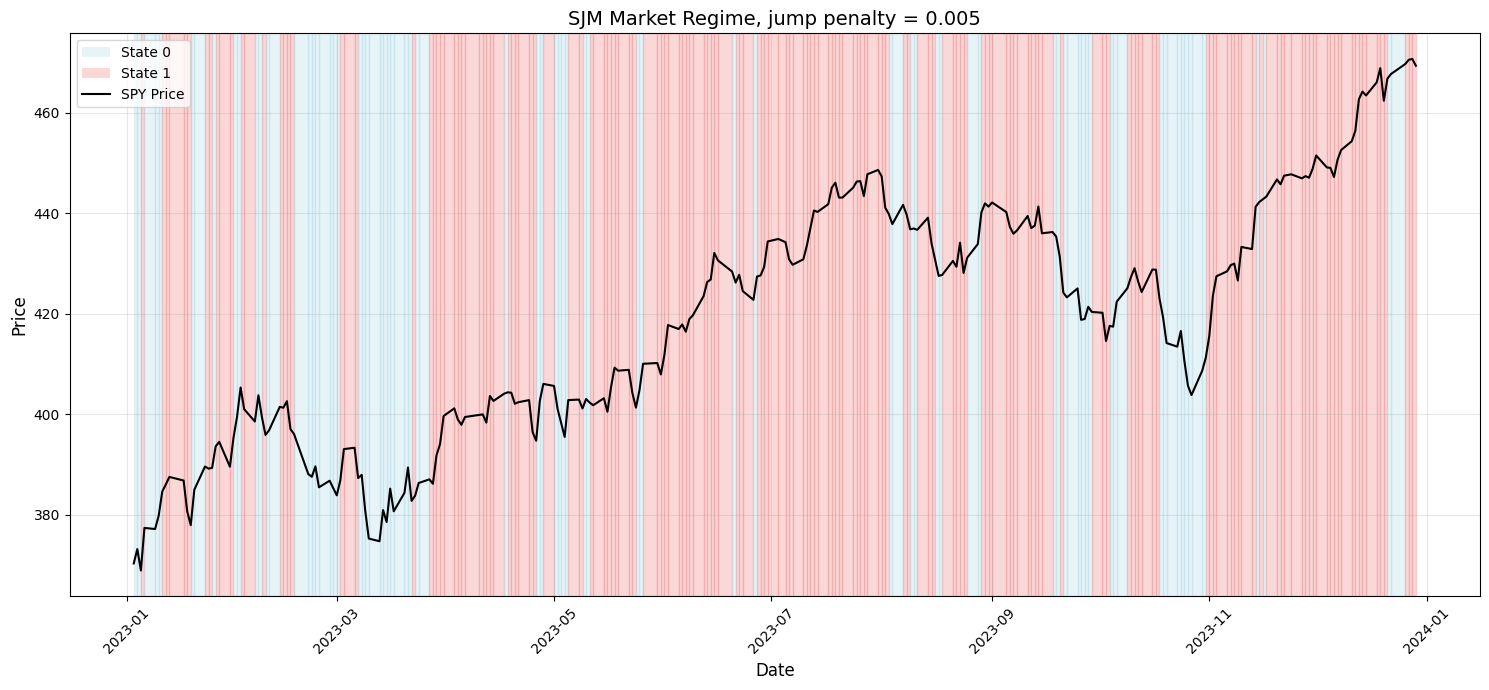

In [196]:
######## Coordinate Descent Algoirthm

jump_penalty = 0.005

# key is the random seed, value is dict of state sequence and centered state features
result_dict = {}

for trial in range(10):
    random_seed = random.randint(0, 1000)
    loss_ls = []
    ii = 0
    # Initialize the fixed state sequence
    state_seq, state_features_ls = initialize_states(df, n_states, random_seed)

    tol = 100000

    while tol > loss_tolerance or ii < 5:
        # 1. Optimize the centered state features, fixing the state sequence
        n_variables = n_states * n_features
        # Initialize the centered state features, which is to be optimized
        state_features = np.concatenate((state_features_ls[0],state_features_ls[1]))

        result = optimize.minimize(
            objective_func,
            state_features,
            method='L-BFGS-B',
            bounds=[(-100, 100) for _ in range(n_variables)],
            options={'maxiter': 1000}
        )

        # Updated centered state features
        state_features_ls = [result.x[i*n_features: (i+1)*n_features] for i in range(n_states)]

        # 2. Optimize the state sequence, fixiing the centered state features.
        dist_matrix = np.zeros((len(df), n_states))
        arr_df = np.array(df)

        for i in range(len(dist_matrix)):
            for j in range(n_states):
                dist_matrix[i,j] = np.sum((np.array(arr_df[i, :]) - state_features_ls[j])**2)

        optimal_states = [0 for _ in range(len(df))]
        loss_matrix = np.zeros((len(df), n_states))

        # Initialized the first row of the loss matrix
        for k in range(n_states):
            loss_matrix[0, k] = dist_matrix[0, k]

        # Loop forward to fill the loss matrix
        for t in range(1, len(df)):
            for k in range(n_states):
                loss_inc = min([loss_matrix[t-1, j] + jump_penalty * int(j!=k) for j in range(n_states)])
                loss_matrix[t, k] = dist_matrix[t, k] + loss_inc

        loss_total = min(loss_matrix[-1, :])

        # Loop backward to find the optimal state sequence
        optimal_states[-1] = int(np.argmin(loss_matrix[-1, :]))

        for t in range(len(df)-2, -1, -1):
            loss_inc_back = [loss_matrix[t,j] + jump_penalty*int(j!=optimal_states[t+1]) for j in range(n_states)]
            optimal_states[t] = int(np.argmin(loss_inc_back))

        # The newly updated state sequence
        state_seq = optimal_states
            
        if ii == 0:
            loss_ls.append(loss_total)
            print(f'Seed {random_seed}: Iteration {ii}, loss {loss_total}')
            ii += 1
            continue
        else:
            tol = np.abs(loss_total - loss_ls[-1])

        loss_ls.append(loss_total)
        print(f'Seed {random_seed}: Iteration {ii}, loss {loss_total}')
        ii += 1

    result_dict[random_seed] = {'state_seq': state_seq, 'state_features_ls': state_features_ls, 'loss_total': loss_total}


results = list(result_dict.values())
results = sorted(results, key=lambda x: x['loss_total'], reverse=True)
state_seq = results[-1]['state_seq']
state_features_ls = results[-1]['state_features_ls']


df_plot = data[['Close', 'r']]
df_plot['state'] = state_seq


plt.figure(figsize=(15, 7))

plt.plot(df_plot.index, df_plot['Close'], 'k-', linewidth=1.5, zorder=2)

# Add shading for different states
for i in range(len(df_plot)-1):
    if df_plot['state'][i] == 0:
        plt.axvspan(df_plot.index[i], df_plot.index[i+1], color='lightblue', alpha=0.3, zorder=1)
    else:
        plt.axvspan(df_plot.index[i], df_plot.index[i+1], color='lightcoral', alpha=0.3, zorder=1)

# Formatting
 # Formatting
plt.title(f'SJM Market Regime, jump penalty = {jump_penalty}', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightblue', alpha=0.3, label='State 0'),
    Patch(facecolor='lightcoral', alpha=0.3, label='State 1'),
    plt.Line2D([0], [0], color='k', label='SPY Price')
]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()


# Continuous Statistical Jump Model

In [205]:
# Parameter settings

df = data.drop(columns=['r', 'Close'])
jump_penalty = 0.0005
n_features = 15
n_data = len(df)

n_states = 2
possible_states = [i for i in range(n_states)]

loss_tolerance = 0.0000001

df

Price,r_yesterday,r_diff_1,r_diff_2,r_mean_6,r_std_6,r_left_mean_6,r_left_std_6,r_right_mean_6,r_right_std_6,r_mean_14,r_std_14,r_left_mean_14,r_left_std_14,r_right_mean_14,r_right_std_14
Date,,,,,,,,,,,,,,,
2023-01-03,-0.263750,2.047778,3.034611,0.004377,1.046831,-0.357379,0.912669,0.366134,1.230475,-0.299484,1.168799,-0.397448,1.314346,-0.201519,1.099985
2023-01-04,-0.421877,0.158127,2.047778,0.036956,1.070854,0.046102,1.564684,0.027810,0.646788,-0.298419,1.169840,-0.710454,1.253896,0.113617,0.998372
2023-01-05,0.769055,1.190932,0.158127,-0.088505,1.171016,0.089899,1.547907,-0.266909,0.967830,-0.334597,1.188939,-0.536883,1.345773,-0.132310,1.075251
2023-01-06,-1.147905,1.916960,1.190932,0.497810,1.341136,0.366134,1.230475,0.629486,1.711878,0.004253,1.207376,-0.239534,1.041263,0.248040,1.391247
2023-01-09,2.267307,3.415212,1.916960,0.191021,1.190095,0.027810,0.646788,0.354233,1.744296,0.085033,1.158334,-0.248527,1.051042,0.418594,1.242094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.943722,2.339131,2.001644,0.125243,0.835858,0.334128,0.432665,-0.083642,1.195219,0.289357,0.660845,0.425589,0.561477,0.153126,0.766588
2023-12-26,0.200763,0.742959,2.339131,0.222934,0.829409,-0.076080,1.142797,0.521947,0.381557,0.320862,0.655469,0.474178,0.530376,0.167545,0.771195
2023-12-27,0.421357,0.220595,0.742959,0.159554,0.812778,0.051516,1.264385,0.267593,0.133543,0.362608,0.623604,0.508322,0.468521,0.216894,0.757312


In [252]:
def initialize_probabilistic_states(df, n_states, state_simplex, random_seed=42):
    """
    Initialize states with probabilistic assignments using state_simplex
    
    Parameters:
    df: DataFrame with features
    n_states: number of states (2)
    n_features: number of features
    state_simplex: 2xn matrix of unit vectors (probability simplexes)
    random_seed: random seed for reproducibility
    
    Returns:
    state_probs: array of shape (n_points, 2) containing probability distributions
    state_features_ls: list of state centers
    """
    # Set random seed
    np.random.seed(random_seed)
    
    # Use k-means for initial clustering
    kmeans = KMeans(
        n_clusters=n_states, 
        random_state=random_seed,
        init='k-means++',
        n_init=10
    )
    
    # Get initial hard assignments
    initial_clusters = kmeans.fit_predict(df)
    
    # Get distances to cluster centers
    distances = kmeans.transform(df)  # Shape: (n_points, n_states)
    
    # Convert distances to probabilities using softmax
    def softmax(x):
        exp_x = np.exp(-x)  # Negative distance for higher prob to closer center
        return exp_x / exp_x.sum(axis=1, keepdims=True)
    
    # Initial probability distributions
    initial_probs = softmax(distances)
    
    # Randomly select columns from state_simplex based on probabilities
    n_points = len(df)
    n_simplex_cols = state_simplex.shape[1]
    
    # For each point, select a column from state_simplex
    # with probability based on initial clustering
    state_probs = np.zeros((n_points, 2))
    for i in range(n_points):
        if initial_probs[i, 0] > initial_probs[i, 1]:
            # More likely state 0, select from first half of simplex
            col_idx = np.random.randint(0, n_simplex_cols // 2)
        else:
            # More likely state 1, select from second half of simplex
            col_idx = np.random.randint(n_simplex_cols // 2, n_simplex_cols)
        state_probs[i] = state_simplex[:, col_idx]
    
    # Get state features from kmeans centers
    state_features_ls = kmeans.cluster_centers_
    
    return state_probs, state_features_ls

In [215]:
def objective_func_continuous(arr):
    state_features_f = []
    for i in range(n_states):
        state_features_f.append(arr[i*n_features: (i+1)*n_features])    

    total_dist = 0

    for k in range(n_states):
        dist_ls = []

        for i in range(len(df)):
            features = np.array(df.iloc[i, :])
            prob = state_probs_seq[i, k]

            diff = np.abs(features - state_features_f[k])
            dist = np.sum(diff**2) * prob
            dist_ls.append(dist)

        total_dist += np.sum(dist_ls)

    return total_dist

In [249]:
def objective_func(arr):
    state_features_f = []
    for i in range(n_states):
        state_features_f.append(arr[i*n_features: (i+1)*n_features])

    dist_ls = []

    for i in range(len(df)):
        features = np.array(df.iloc[i, :])
        state = state_seq[i]

        diff = np.abs(features - state_features_f[state])
        dist = np.sum(diff**2)
        dist_ls.append(dist)

    dist_total = np.sum(dist_ls)

    return dist_total

In [254]:
n_state_simplex = 30
# Generate random positive 2xn matrix using uniform distribution
state_simplex = np.random.uniform(0, 1, (2, n_state_simplex))

# Normalize each column to have sum of squares = 1
norms = np.sqrt(np.sum(state_simplex**2, axis=0))
state_simplex = state_simplex / norms[np.newaxis, :]


loss_tolerance = 0.01


jump_penalty = 0.005

# key is the random seed, value is dict of state probability sequence and centered state features
result_dict = {}

for trial in range(5):
    random_seed = random.randint(0, 1000)


    state_probs_seq, state_features_ls = initialize_probabilistic_states(df, 2, state_simplex, random_seed)
    state_features = np.concatenate((state_features_ls[0],state_features_ls[1]))

    loss_ls = []
    tol = 100000
    ii = 0
    while tol > loss_tolerance or ii < 5:

        # Optimize the state features, fixing the state probabilitysequence
        result = optimize.minimize(
                    objective_func_continuous,
                    state_features,
                    method='L-BFGS-B',
                    bounds=[(-100, 100) for _ in range(n_variables)],
                    options={'maxiter': 1000}
                )

        state_features_ls = [result.x[i*n_features: (i+1)*n_features] for i in range(n_states)]

        # 2. Optimize the state probabilitysequence, fixing the centered state features.
        dist_matrix = np.zeros((len(df), n_states))
        arr_df = np.array(df)

        for i in range(len(dist_matrix)):
            for j in range(n_states):
                dist_matrix[i,j] = np.sum((np.array(arr_df[i, :]) - state_features_ls[j])**2)

        dist_matrix_complex = dist_matrix @ state_simplex

        jump_penalty_matrix = np.zeros((n_state_simplex, n_state_simplex))
        for i in range(n_state_simplex):
            for j in range(n_state_simplex):
                prob_dist = np.sum((state_simplex[:,i] - state_simplex[:,j]) ** 2) / n_states
                jump_penalty_matrix[i,j] = jump_penalty / 4 * prob_dist
                

        loss_matrix = np.zeros((len(df), n_state_simplex))

        for n in range(n_state_simplex):
            loss_matrix[0, n] = dist_matrix_complex[0, n]

        for t in range(1, len(df)):
            for n in range(n_state_simplex):
                loss_inc = min([loss_matrix[t-1, j] + jump_penalty_matrix[j, n] for j in range(n_state_simplex)])
                loss_matrix[t, n] = dist_matrix_complex[t, n] + loss_inc


        state_probs_seq = np.zeros((len(df), n_states))
        state_index_seq = [0 for _ in range(len(df))]


        loss_total = min(loss_matrix[-1, :])
        optimal_state_index = np.argmin(loss_matrix[-1, :])
        state_index_seq[-1] = int(optimal_state_index)
        state_probs_seq[-1, :] = state_simplex[:, optimal_state_index]

        for t in range(len(df)-2, -1, -1):
            loss_inc_back = [loss_matrix[t,j] + jump_penalty_matrix[j, state_index_seq[t+1]] for j in range(n_state_simplex)]
            optimal_state_index = np.argmin(loss_inc_back)
            state_index_seq[t] = int(optimal_state_index)
            state_probs_seq[t,:] = state_simplex[:, optimal_state_index]

        if ii == 0:
            loss_ls.append(loss_total)
            print(f'Seed {random_seed}: Iteration {ii}, loss {loss_total}')
            ii += 1
            continue
        else:
            tol = np.abs(loss_total - loss_ls[-1])

        loss_ls.append(loss_total)
        print(f'Seed {random_seed}: Iteration {ii}, loss {loss_total}')
        ii += 1

        result_dict[random_seed] = {'state_probs_seq': state_probs_seq, 'state_features_ls': state_features_ls, 'loss_total': loss_total}


results = list(result_dict.values())
results = sorted(results, key=lambda x: x['loss_total'], reverse=True)
state_probs_seq = results[-1]['state_probs_seq']
state_features_ls = results[-1]['state_features_ls']


print(state_features_ls)
print(state_probs_seq)


Seed 568: Iteration 0, loss 779.8665217319531
Seed 568: Iteration 1, loss 778.2583122958049
Seed 568: Iteration 2, loss 724.2196577369461
Seed 568: Iteration 3, loss 691.5436034648391
Seed 568: Iteration 4, loss 681.5175646639005
Seed 568: Iteration 5, loss 680.8345792825747
Seed 568: Iteration 6, loss 680.7522079331055
Seed 568: Iteration 7, loss 680.7522079331055
Seed 831: Iteration 0, loss 779.771565091052
Seed 831: Iteration 1, loss 745.466978260188
Seed 831: Iteration 2, loss 696.5892315931662
Seed 831: Iteration 3, loss 691.9647680312675
Seed 831: Iteration 4, loss 689.8293039947374
Seed 831: Iteration 5, loss 689.1650071403351
Seed 831: Iteration 6, loss 688.0209899143864
Seed 831: Iteration 7, loss 686.9174206159323
Seed 831: Iteration 8, loss 684.7730719745791
Seed 831: Iteration 9, loss 683.6403067402774
Seed 831: Iteration 10, loss 682.847153484664
Seed 831: Iteration 11, loss 682.4733504821116
Seed 831: Iteration 12, loss 682.4492331675792
Seed 831: Iteration 13, loss 682.4

/var/folders/4f/6jz6fz0s5qzb8bn1kt7qww900000gn/T/ipykernel_3805/1637184887.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['state'] = state_seq
/var/folders/4f/6jz6fz0s5qzb8bn1kt7qww900000gn/T/ipykernel_3805/1637184887.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df_plot['state'][i] == 0:


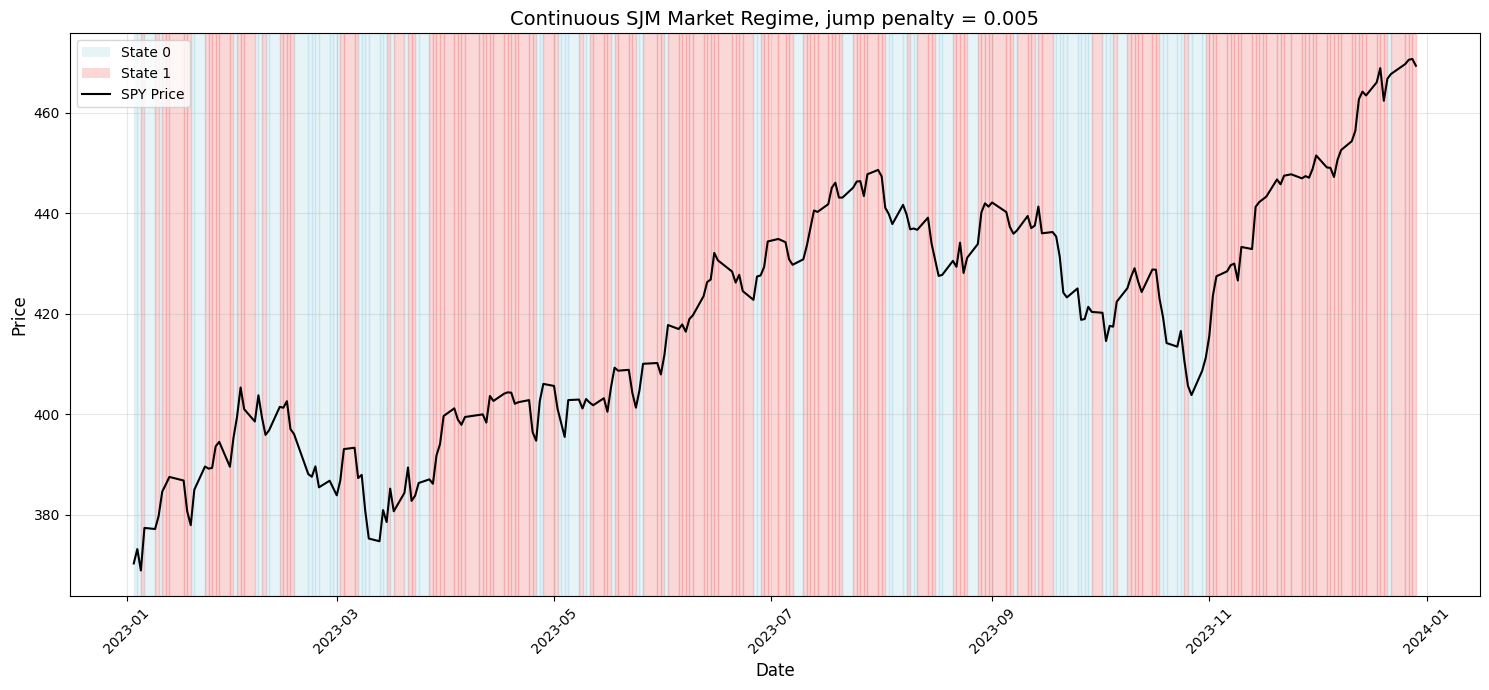

In [256]:
state_seq = [0 for _ in range(len(df))]

for i in range(state_probs_seq.shape[0]):
    state_seq[i] = np.argmax(state_probs_seq[i, :])

df_plot = data[['Close', 'r']]
df_plot['state'] = state_seq

plt.figure(figsize=(15, 7))

plt.plot(df_plot.index, df_plot['Close'], 'k-', linewidth=1.5, zorder=2)

# Add shading for different states
for i in range(len(df_plot)-1):
    if df_plot['state'][i] == 0:
        plt.axvspan(df_plot.index[i], df_plot.index[i+1], color='lightblue', alpha=0.3, zorder=1)
    else:
        plt.axvspan(df_plot.index[i], df_plot.index[i+1], color='lightcoral', alpha=0.3, zorder=1)

# Formatting
 # Formatting
plt.title(f'Continuous SJM Market Regime, jump penalty = {jump_penalty}', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightblue', alpha=0.3, label='State 0'),
    Patch(facecolor='lightcoral', alpha=0.3, label='State 1'),
    plt.Line2D([0], [0], color='k', label='SPY Price')
]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()
